In [1]:
from dataclasses import asdict, dataclass

import numpy as np
import seaborn as sns
import torch
import wandb
from contextual_distros import ContextualLatentSpaceGMM, ContextDataset
from dvi_process import DIS
from matplotlib import pyplot as plt
from score_function import ScoreFunction
from torch.distributions import Normal
from torch.utils.data import DataLoader
from train import train

In [2]:
import torch_directml
device =  torch.device("cpu") # torch_directml.device() 

In [3]:
@dataclass
class Config():
    num_steps = 16
    c_dim = 2
    z_dim = 2
    h_dim = 32
    num_layers = 3
    non_linearity = "SiLU"
    learning_rate = 3e-4
    size=4096
    batch_size = 4096

config = Config()

In [4]:
dataset = ContextDataset(size=config.size, c_dim=config.c_dim)
dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True)

In [5]:
score_function = ScoreFunction(
    c_dim=config.c_dim, 
    h_dim=config.h_dim, 
    z_dim=config.z_dim, 
    num_layers=config.num_layers, 
    non_linearity=config.non_linearity, 
    num_steps=config.num_steps
)

dvi_process = DIS(
    device=device, 
    z_dim=config.z_dim, 
    num_steps=config.num_steps, 
    score_function=score_function
).to(device)

optimizer = torch.optim.Adam(dvi_process.parameters(), lr=config.learning_rate)

In [6]:
target_constructor = ContextualLatentSpaceGMM

In [7]:
wandb_logging = True
if wandb_logging:
    wandb.init(project="dvi", config=asdict(config))

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: max-burzer (max-burzer-karlsruhe-institute-of-technology). Use `wandb login --relogin` to force relogin


In [55]:
losses = train(
    dvi_process, 
    device, 
    dataloader, 
    optimizer, 
    2000, 
    target_constructor,
    wandb_logging=wandb_logging
)

100%|██████████| 1/1 [00:00<00:00,  2.60it/s, epoch=1999, loss=2.37]


/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'contextual_distros.ContextualLatentSpaceGMM'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


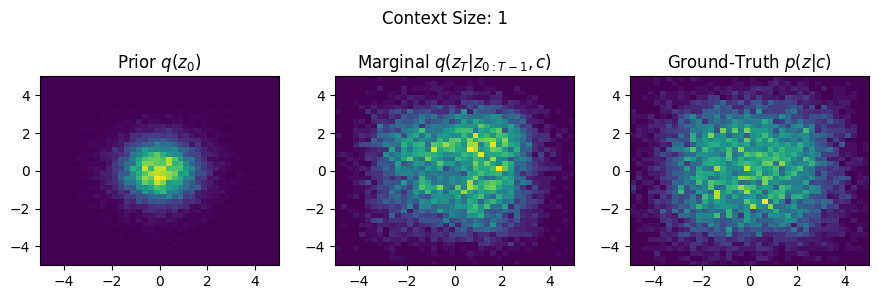

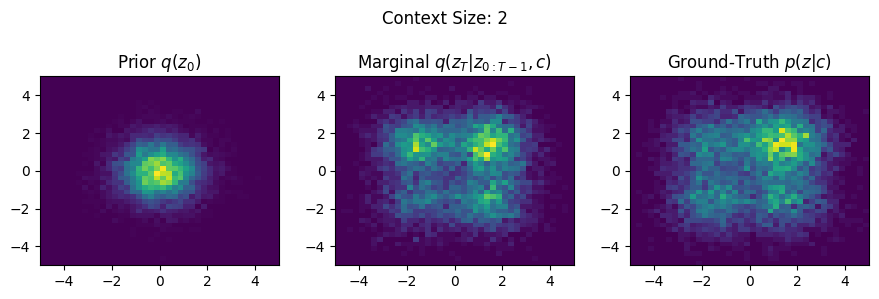

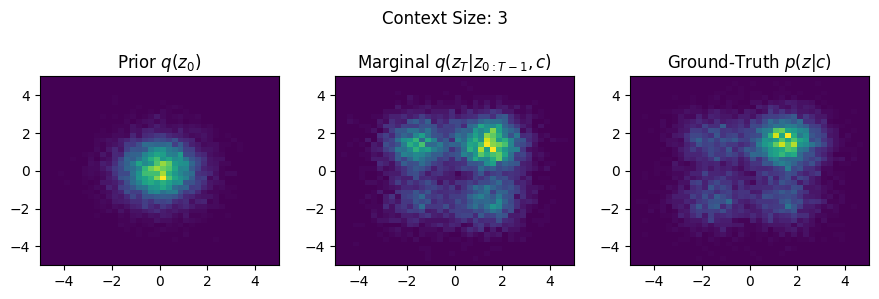

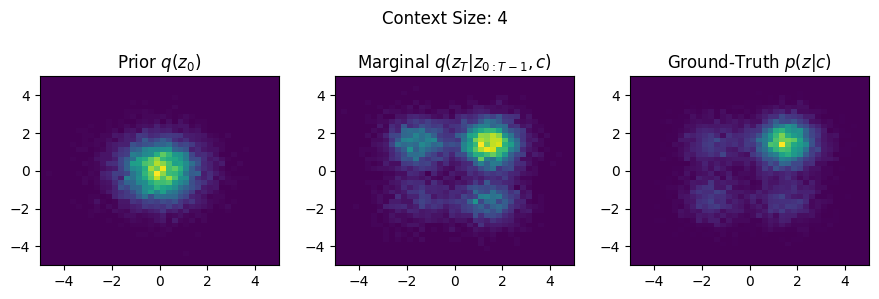

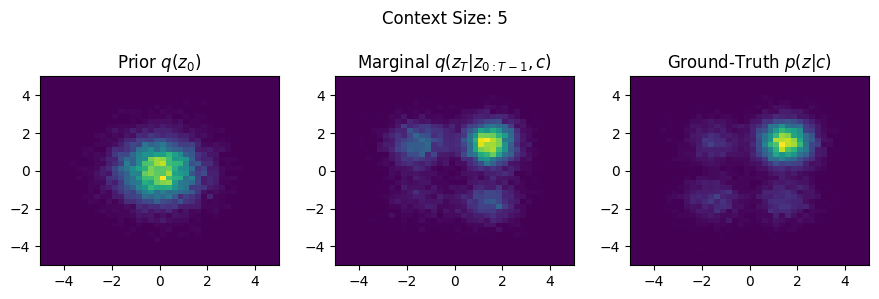

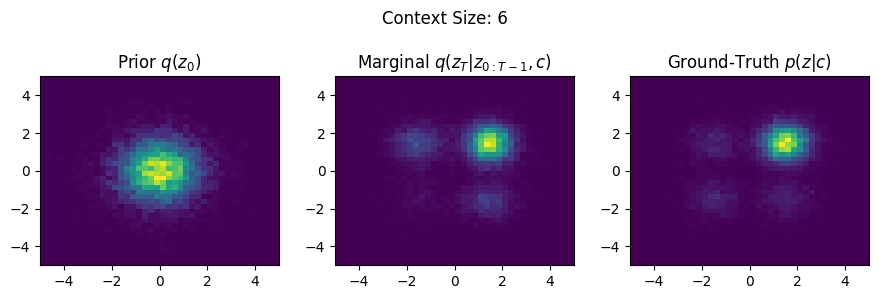

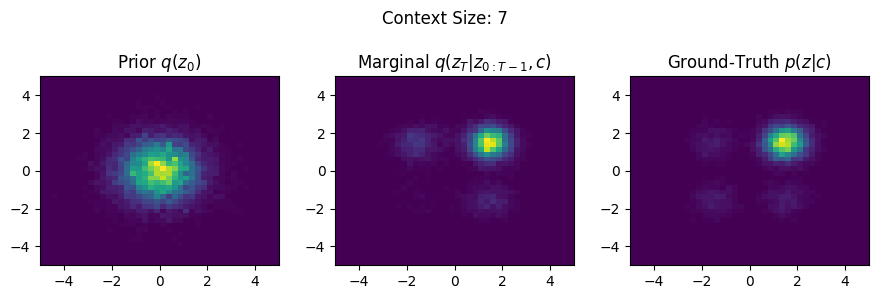

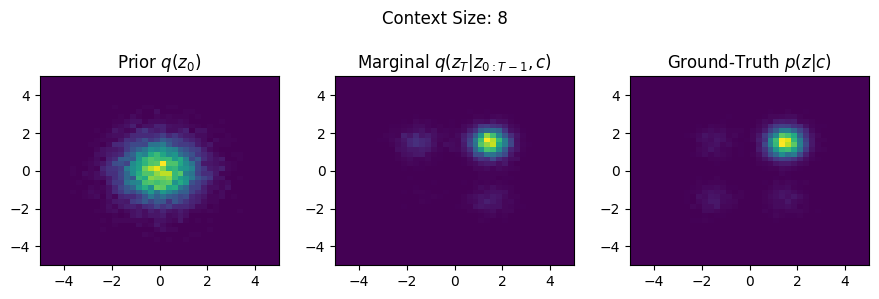

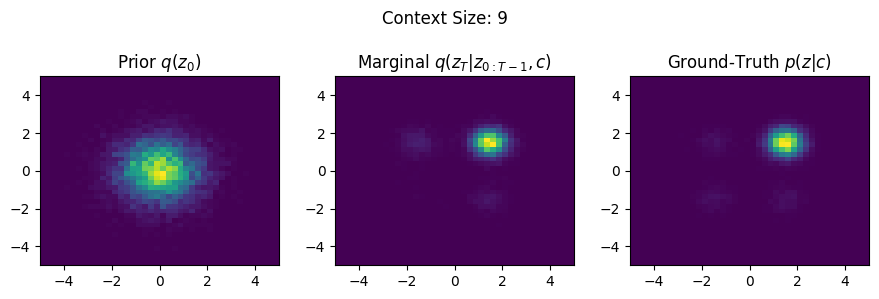

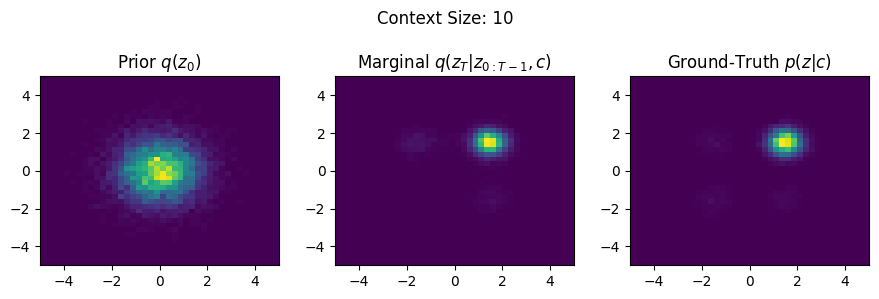

In [69]:
num_samples = 10000

for context_size in range(1, 11):

    context = 3 * torch.rand((num_samples, context_size, config.c_dim), device=device)

    p_z_0 = Normal(
        torch.zeros((num_samples, config.z_dim), device=device),
        torch.ones((num_samples, config.z_dim), device=device) # * dvi_process.sigmas[0],
    )

    p_z_T = target_constructor(context)

    z_target_samples = p_z_T.sample()

    dvi_process.eval()
    with torch.no_grad():
        _, z_samples = dvi_process.run_chain(p_z_0, p_z_T, context.to(device))

        z_0_samples = z_samples[0]
        z_T_samples = z_samples[-1]

        z_trajectories = [[z[i, :].cpu().numpy() for z in z_samples] for i in range(num_samples)]

    bins = 40
    plot_range = [(-5, 5), (-5, 5)]

    fig, ax = plt.subplots(1, 3, figsize=(9, 3), gridspec_kw={'width_ratios': [1, 1, 1]})

    ax[0].hist2d(z_0_samples[:, 0], z_0_samples[:, 1], bins=bins, range=plot_range)
    ax[0].set_title("Prior $q(z_0)$")

    ax[1].hist2d(z_T_samples[:, 0], z_T_samples[:, 1], bins=bins, range=plot_range)
    ax[1].set_title("Marginal $q(z_T|z_{0:T-1},c)$")

    ax[2].hist2d(z_target_samples[:, 0], z_target_samples[:, 1], bins=bins, range=plot_range)
    ax[2].set_title("Ground-Truth $p(z|c)$")

    plt.suptitle("Context Size: {}".format(context_size))
    plt.tight_layout()
    plt.show()

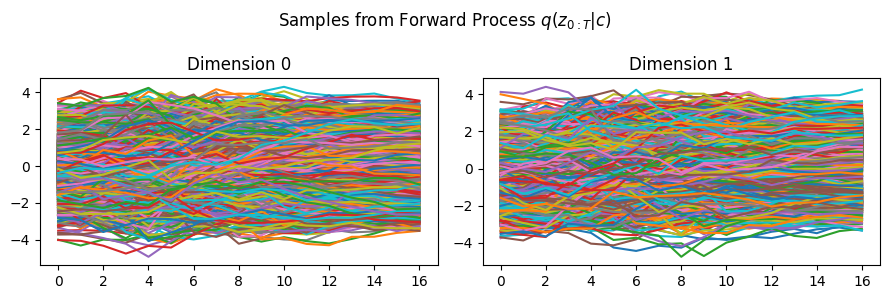

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3), gridspec_kw={'width_ratios': [1, 1]})

for i in range(num_samples):
    ax[0].plot([z[0] for z in z_trajectories[i]])
    ax[0].set_title("Dimension 0")

    ax[1].plot([z[1] for z in z_trajectories[i]])
    ax[1].set_title("Dimension 1")
    
plt.suptitle("Samples from Forward Process $q(z_{0:T}|c)$")

plt.tight_layout()
plt.show()